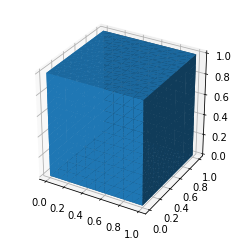

In [2]:
from __future__ import print_function
from fenics import *
import numpy as np
import dolfin as df
import os 
import matplotlib.pyplot as plt

# Create mesh and define function space

l = 1.0 
p0 = (0.0, 0.0, 0.0)
p1 = (l, l, 0.0)
nx = 20.0
ny = 20.0
nz = 1.0
#point source de chaleur
p2=(5., 5.)

mesh = BoxMesh(Point(0,0, 0), Point(1, 1, 1), 10, 10, 10, )

plot(mesh)


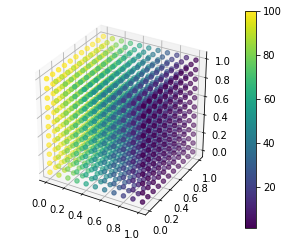

In [3]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 1.0)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 


bcs = [DirichletBC(V, Constant(0), East()),
       DirichletBC(V, Constant(1), West())]

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)



# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
graph=plot(u)
#plt.colorbar(cax=x[0],0. , mappable, **kwargs)[source]
plt.colorbar(graph);

### Source ponctuelle

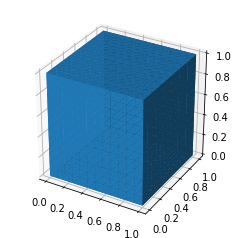

In [4]:
from dolfin import *
nbrnoeuds = 12
mesh2 = BoxMesh(Point(0,0, 0), Point(1, 1, 1), nbrnoeuds, nbrnoeuds , nbrnoeuds)
plot(mesh2)

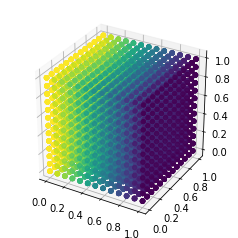

In [5]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh2, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 1.0)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 


bcs = [DirichletBC(V, Constant(0), East()),
       DirichletBC(V, Constant(1), West())]

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


A, b = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0,0,0.5), 1000)
delta.apply(b)


# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
    graph=plot(u)
   #plt.colorbar(graph);

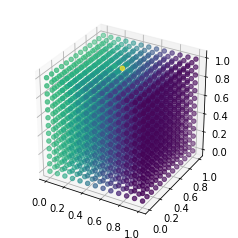

In [6]:
class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(1.), NoslipBoundary()), 
       DirichletBC(V, Constant(0.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


#a = inner(grad(u), grad(v))*dx
#L = Constant(0)*v*dx
A, l = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0.5, 0.5,1.), 1.)
delta.apply(l)

u = Function(V)

solve(A, u.vector(),l)
plot(u)

## Avec le temps

In [44]:
#for t in [ 0,2,4,6,8,10,12]:

class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)
n_steps = 20
print("uqleuqe chose" ,t)

for step in range(n_steps):
    
    x = (t/n_steps)*nbrnoeuds
    y = 0.5
    z = 1.

    #a = inner(grad(u), grad(v))*dx
    #L = Constant(0)*v*dx
    A, b = assemble_system(a, L, b_T)

     # Update current time
    t += dt
    print(x)
    #delta.set_point(t)
    #delta.apply(b)
    delta = PointSource(V, Point(x,y,z), 10.)
    delta.apply(b)

    u = Function(V)

    solve(A, u.vector(), b)
    plot(u,interactive = True )

uqleuqe chose 1.2874999999999974
0.7724999999999985


AttributeError: Unknown property interactive

0.0125
0
0.0
0.5
0
20
0.0125
0.0125
0.0075
0.5
1
20
0.0125
0.025
0.015
0.5
2
20
0.0125
0.037500000000000006
0.022500000000000006
0.5
3
20
0.0125
0.05
0.03
0.5
4
20
0.0125
0.0625
0.037500000000000006
0.5
5
20
0.0125
0.075
0.045
0.5
6
20
0.0125
0.0875
0.05249999999999999
0.5
7
20
0.0125
0.09999999999999999
0.05999999999999999
0.5
8
20
0.0125
0.11249999999999999
0.0675
0.5
9
20
0.0125
0.12499999999999999
0.075
0.5
10
20
0.0125
0.13749999999999998
0.08249999999999999
0.5
11
20
0.0125
0.15
0.09
0.5
12
20
0.0125
0.1625
0.0975
0.5
13
20
0.0125
0.17500000000000002
0.10500000000000001
0.5
14
20
0.0125
0.18750000000000003
0.11250000000000002
0.5
15
20
0.0125
0.20000000000000004
0.12000000000000002
0.5
16
20
0.0125
0.21250000000000005
0.12750000000000003
0.5
17
20
0.0125
0.22500000000000006
0.13500000000000004
0.5
18
20
0.0125
0.23750000000000007
0.14250000000000004
0.5
19
20


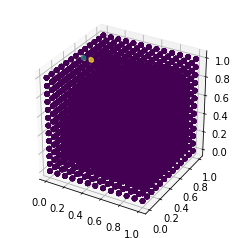

In [34]:
#matplotlib notebook

V = FunctionSpace(mesh2, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = Constant(0)*v*dx
bc = DirichletBC(V, Constant(0), DomainBoundary())
A, b = assemble_system(a, L, bc)

u = Function(V)
n_steps = 20
dt = 1./(4*n_steps)
t = 0

for step in range(n_steps):
   
    x = (t/n_steps)*nbrnoeuds
    y = 0.5
    z = 1.
    print(dt)
    print(t)
    print(x)
    print(y)
    print(step)
    print(n_steps)
#    cn = cos(2*pi*step*dt)
#    sn = sin(2*pi*step*dt)
#    den = (1 + sn**2)
#Point(0.5, 0.5,1.), 1.
    delta = PointSource(V, Point(x, y,z), 10.)
    delta.apply(b)
    solve(A, u.vector(), b)
    
    plot(u)
    t += dt
    # reset rhs
    b.zero()
    bc.apply(b) 

In [19]:
class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

#dolfin_eps= eps tres petit comme d'hab
class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(1.), NoslipBoundary()), 
       DirichletBC(V, Constant(0.), NoslipBoundary2())] 

V = FunctionSpace(mesh2,"CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)


#a = inner(grad(u), grad(v))*dx
#L = Constant(0)*v*dx
A, l = assemble_system(a, L, b_T)

delta = PointSource(V, Point(0.5, 0.5,1.), 0.5)
delta.apply(l)

u = Function(V)

solve(A, u.vector(),l)
plot(u)

Found domains with different geometric dimensions.


UFLException: Found domains with different geometric dimensions.

/opt/fenics-2018.1/lib/python3.5/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'interactive'
  s)


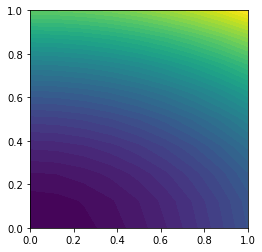

In [15]:
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u, interactive = True)

    # Compute error at vertices
   # u_e = interpolate(u_D, V)
   # error = np.abs(u_e.vector().array() - u.vector().array()).max()
   # print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
#interactive()